In [9]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
# Load the CSV
df = pd.read_csv("date_colesterol.csv")
x = df["Ore_Exercitii"].values
y = df["Colesterol"].values


In [ ]:
def build_mixture_model_fixed(x, y, K):
    with pm.Model() as model:
        w = pm.Dirichlet("w", a=np.ones(K))
        
        alpha = pm.Normal("alpha", mu=200, sigma=50, shape=K)
        beta  = pm.Normal("beta", mu=0, sigma=20, shape=K)
        gamma = pm.Normal("gamma", mu=0, sigma=5, shape=K)
        
        sigma = pm.HalfNormal("sigma", sigma=20, shape=K)
        
        comp_dists = []
        for k in range(K):
            mu_k = alpha[k] + beta[k]*x + gamma[k]*x**2
            comp_dists.append(pm.Normal.dist(mu=mu_k, sigma=sigma[k]))
        
        y_obs = pm.Mixture("y_obs", w=w, comp_dists=comp_dists, observed=y)
        
    return model


In [3]:
traces = {}
for K in [3, 4, 5]:
    model = build_mixture_model_fixed(x, y, K)
    with model:
        trace = pm.sample(100, tune=100, target_accept=0.9, random_seed=42, idata_kwargs={"log_likelihood": True})
        traces[K] = trace


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, alpha, beta, gamma, sigma]


Output()

Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 11 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, alpha, beta, gamma, sigma]


Output()

Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 18 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, alpha, beta, gamma, sigm

Output()

Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 26 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [4]:
for K, trace in traces.items():
    print(f"\n=== K = {K} ===")
    w_mean = trace.posterior['w'].mean(dim=["chain","draw"]).values
    alpha_mean = trace.posterior['alpha'].mean(dim=["chain","draw"]).values
    beta_mean  = trace.posterior['beta'].mean(dim=["chain","draw"]).values
    gamma_mean = trace.posterior['gamma'].mean(dim=["chain","draw"]).values
    sigma_mean = trace.posterior['sigma'].mean(dim=["chain","draw"]).values
    
    print("Weights:", w_mean)
    print("Alpha:", alpha_mean)
    print("Beta:", beta_mean)
    print("Gamma:", gamma_mean)
    print("Sigma:", sigma_mean)



=== K = 3 ===
Weights: [0.33419521 0.32267774 0.34312705]
Alpha: [223.30527033 235.16558204 212.83414573]
Beta: [-6.09411916 -4.63940546 -4.16556775]
Gamma: [ 0.22591957 -0.02525208  0.28810935]
Sigma: [6.11526055 8.12488772 5.55910491]

=== K = 4 ===
Weights: [0.23848228 0.24578139 0.24645222 0.2692841 ]
Alpha: [215.21672344 239.19308616 209.89914377 232.08726487]
Beta: [-4.23983831 -4.41423766 -4.32297429 -4.45127132]
Gamma: [ 0.21737495  0.04967497  0.12045005 -0.04976744]
Sigma: [5.33785197 6.2634705  4.90841417 5.93360408]

=== K = 5 ===
Weights: [0.27203315 0.20507013 0.13317409 0.16893248 0.22079015]
Alpha: [214.34885846 235.14554954 200.15379939 202.13099874 218.38554045]
Beta: [-3.74590619 -1.39683836  4.80657065  3.14942903 -8.4127193 ]
Gamma: [ 0.26380809 -0.22487505 -0.66137706  0.18297818  0.27692014]
Sigma: [7.09625455 6.69068925 9.66473525 7.49693353 7.3852892 ]


In [ ]:
model_dict = {K: traces[K] for K in [3,4,5]}
loo_dict = {}
waic_dict = {}

for K, trace in traces.items():
    loo_dict[K] = az.loo(trace, pointwise=True)
    waic_dict[K] = az.waic(trace, pointwise=True)

az.compare({f"K={K}": traces[K] for K in [3,4,5]}, ic="loo")
az.compare({f"K={K}": traces[K] for K in [3,4,5]}, ic="waic")


# Din cate se poate vedea, se pare ca k=5 clusterizeaza cel mai bine datele


/Users/stefaniancu/Documents/An 3 Seminare/PMP/PMP-2025/.venv/lib/python3.13/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.62 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/stefaniancu/Documents/An 3 Seminare/PMP/PMP-2025/.venv/lib/python3.13/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/stefaniancu/Documents/An 3 Seminare/PMP/PMP-2025/.venv/lib/python3.13/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parame

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
K=5,0,-2043.404670,23.079983,0.000000,0.504026,12.108144,0.000000,False,log
K=4,1,-2043.417036,23.231581,0.012366,0.495974,12.644911,1.682124,True,log
K=3,2,-2055.616353,24.985027,12.211683,0.000000,12.276776,2.532877,False,log


In [7]:
def plot_mixture_curves(x, y, trace, K):
    x_grid = np.linspace(min(x)-1, max(x)+1, 200)
    
    # Extract posterior means
    alpha_mean = trace.posterior['alpha'].mean(dim=["chain","draw"]).values
    beta_mean = trace.posterior['beta'].mean(dim=["chain","draw"]).values
    gamma_mean = trace.posterior['gamma'].mean(dim=["chain","draw"]).values
    w_mean = trace.posterior['w'].mean(dim=["chain","draw"]).values
    
    # Plot data
    plt.figure(figsize=(8,6))
    plt.scatter(x, y, color='black', label='Data')
    
    # Plot each component
    for k in range(K):
        y_k = alpha_mean[k] + beta_mean[k]*x_grid + gamma_mean[k]*x_grid**2
        plt.plot(x_grid, y_k, label=f'Component {k+1} (w={w_mean[k]:.2f})')
    
    plt.xlabel('Hours of Exercise')
    plt.ylabel('Cholesterol')
    plt.title(f'Mixture Model Regression Curves for K={K}')
    plt.legend()
    plt.show()



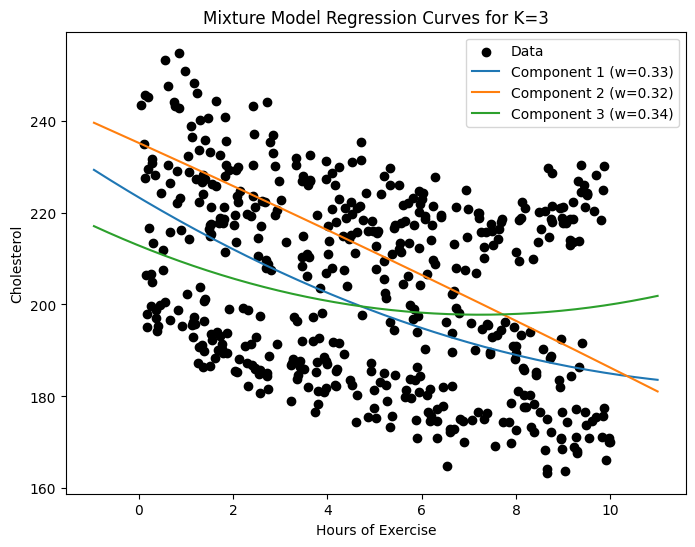

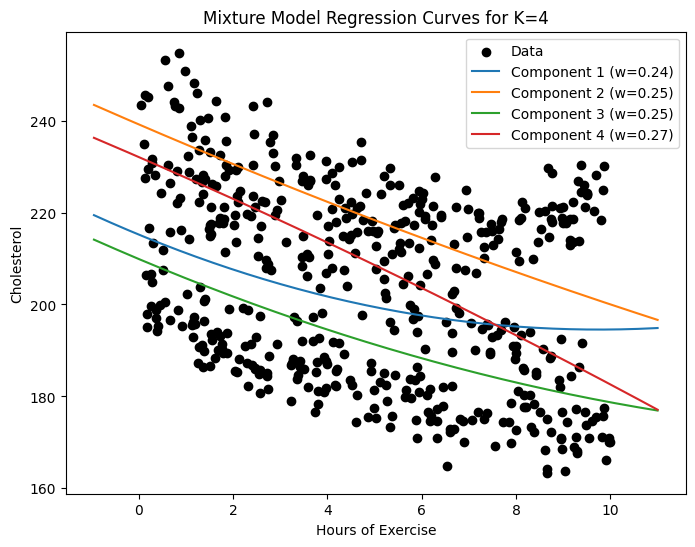

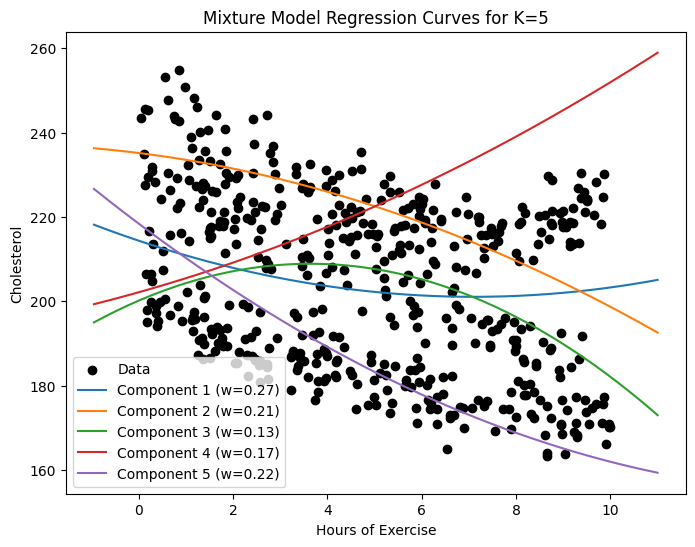

In [10]:
for k in [3, 4, 5]:
    plot_mixture_curves(x, y, traces[k], k)